# Project Proposal: Predicting User Knowledge from Study Habits and Exam Performance


**Group 23** <br>
Allison Fellhauer (38395166) <br>
Agastya Kaul (78851433) <br>
Grace Li (27986504) <br>
Xiangyuan Li (57380230) <br>

## Introduction: Data set and background information

### Background Information

#### User Modeling and User Knowledge

User modeling is used to create a representation of a user based on their interactions with the system ([Chignell & Hancock, 1988](https://doi.org/10.1016/B978-0-444-70536-5.50051-8)). This model can be used to personalize and improve a user’s experience  ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). For example, in e-learning, a user model can be used to track a student’s knowledge level to adapt their learning experience ([Al-Tarabily et al. 2018](https://doi.org/10.1109/ACCESS.2018.2847334)) .

In the dataset [User Knowledge Modeling](https://doi.org/10.24432/C5231X), the authors investigate which user interactions should be used to create the best user knowledge model ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). The goal is to dynamically adjust the student’s learning experience by building a model that classifies their knowledge-level ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

### About the data set

**Our data set:** [User Knowledge Modeling](https://doi.org/10.24432/C5231X)

We have chosen to explore the User Knowledge Modeling data set, which is a data set that classifies users' knowledge of a topic (Electrical DC machines) ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

There are 6 total variables in the data set: 5 features and 1 target.

Features: <br>
A) Goal topics (learning objects):
- The degree of time spent studying the material [STG]
- The degree of repetition of the material [SCG]
- The performance in exams [PEG]

B) Prerequisite topics
- The degree of study time corresponding to the prerequisite objects [STR]
- The knowledge level of the prerequisite objects [LPR]

Target:
- user knowledge [UNS].

UNS has four levels:
- very low (beginner)
- low (intermediate)
- middle (expert) 
- high (advanced)

### Our Question

**Can we predict the knowledge level of a user given their study habits and their performance on the exam?**

We classify study habits as the time spent studying and the degree of repetition, which contributes to increased learning. Exam performance is a way to assess learning.

## Preliminary exploratory data analysis

### Loading necessary libraries and reading in the data

In [1]:
#load all necessarily libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("RColorBrewer")
library(RColorBrewer)

#read data from the web (GitHub raw file)
dc_machines <- read_csv("https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv")
head(dc_machines)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


### Make data usable and readable

Looking at the values, the format is tidy. To make the data usable, UNS (user_knowledge) needs to be converted from a character to a factor. To increase readability, we renamed all variables. We [checked for any missing data](https://www.tutorialspoint.com/dealing-with-missing-data-in-r) and [printed the result](https://www.geeksforgeeks.org/printing-output-of-an-r-program/). There are no missing values.

In [2]:
dc_machines_mutate <- dc_machines |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repetition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS)
missing <- sum(is.na(dc_machines_mutate)) # check for missing values
print(paste("Number of missing values: ", missing))

[1] "Number of missing values:  0"


In [3]:
head(dc_machines_mutate) # view data

study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


### Split the data into training and testing sets

To ensure reproducibility, we set the seed. We used a proportion of 0.75 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [4]:
set.seed(200) #set seed to be reproducible
#create the initial split of the data
#stratify based on user_knowledge
dc_machines_split <- initial_split(dc_machines_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
dc_machines_training <- training(dc_machines_split)
dc_machines_testing <- testing(dc_machines_split)

glimpse(dc_machines_training)

Rows: 192
Columns: 6
$ study_time_goal     <dbl> 0.080, 0.180, 0.100, 0.090, 0.080, 0.200, 0.130, 0…
$ repetition          <dbl> 0.080, 0.180, 0.100, 0.300, 0.325, 0.450, 0.390, 0…
$ study_time_related  <dbl> 0.100, 0.550, 0.700, 0.680, 0.620, 0.280, 0.850, 0…
$ performance_related <dbl> 0.24, 0.30, 0.15, 0.18, 0.94, 0.31, 0.38, 0.71, 0.…
$ performance_goal    <dbl> 0.90, 0.81, 0.90, 0.85, 0.56, 0.78, 0.77, 0.90, 0.…
$ user_knowledge      <fct> High, High, High, High, High, High, High, High, Hi…


### Summarizing the data

We examined how balanced or unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable. 

The very_low (beginner) knowledge level is not as represented in this data set.

In [5]:
summary_counts <- dc_machines_training |>
    group_by(user_knowledge) |> #group based on the class
    summarize(count = n()) #gets the count (number of observations of each)
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


**Table 1**: Proportion of observations classified as each user knowledge level (very_low, low, high, middle)

We then summarized the means of our predictors for each class.

In [6]:
summary <- dc_machines_training |>
    select(user_knowledge, study_time_goal, repetition, performance_goal) |> 
    #select only the class and the predictors
    group_by(user_knowledge) |>
    summarize("mean_study_time" = mean(study_time_goal), "mean_repetition" = mean(repetition),
              "mean_exam_score" = mean(performance_goal)) 
    #get the mean for each predictor for each group
summary

user_knowledge,mean_study_time,mean_repetition,mean_exam_score
<fct>,<dbl>,<dbl>,<dbl>
very_low,0.3172000,0.1787500,0.0985000
High,0.4220000,0.4170426,0.7646809
Low,0.3249831,0.3482542,0.2386949
Middle,0.4147727,0.3676061,0.5430303


**Table 2**: Mean study time and mean exam score for each user knowledge level (very_low, low, middle, high)

### Visualize the data

We visualized the distribution of the different groups according to their counts. Again, this highlights that the data is not completely balanced.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

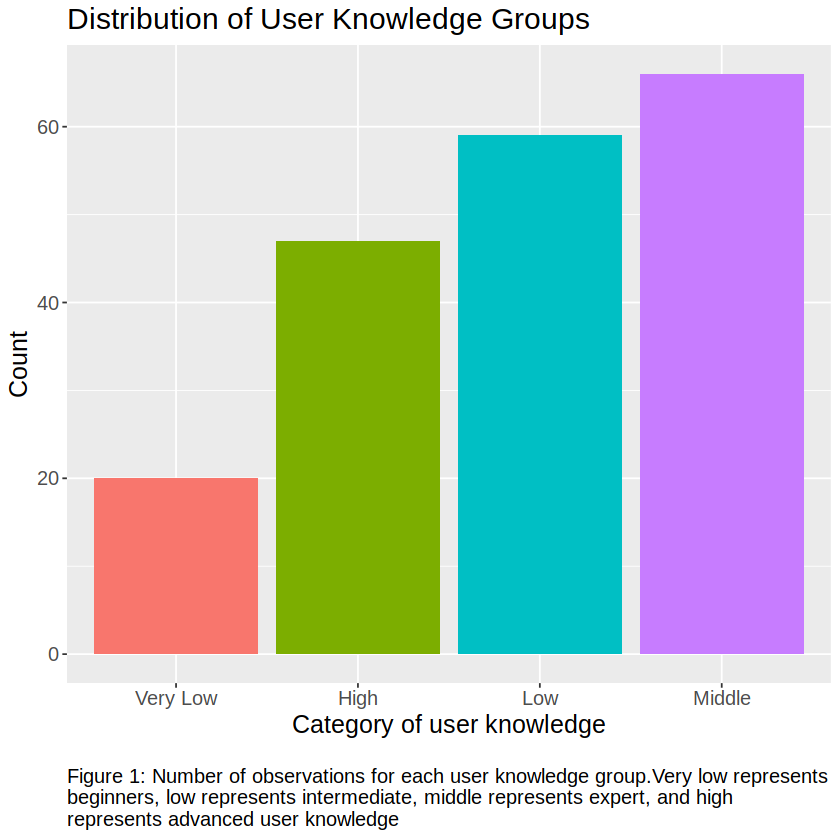

In [7]:
dc_machines_plot_distribution <- dc_machines_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
dc_machines_plot_distribution <- dc_machines_plot_distribution +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups") +
    labs(caption = "
Figure 1: Number of observations for each user knowledge group.Very low represents 
beginners, low represents intermediate, middle represents expert, and high 
represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
dc_machines_plot_distribution

Then, we plotted the data according to study time and exam performance of each of the user knowledge groups. We start to see some distinct groups form.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

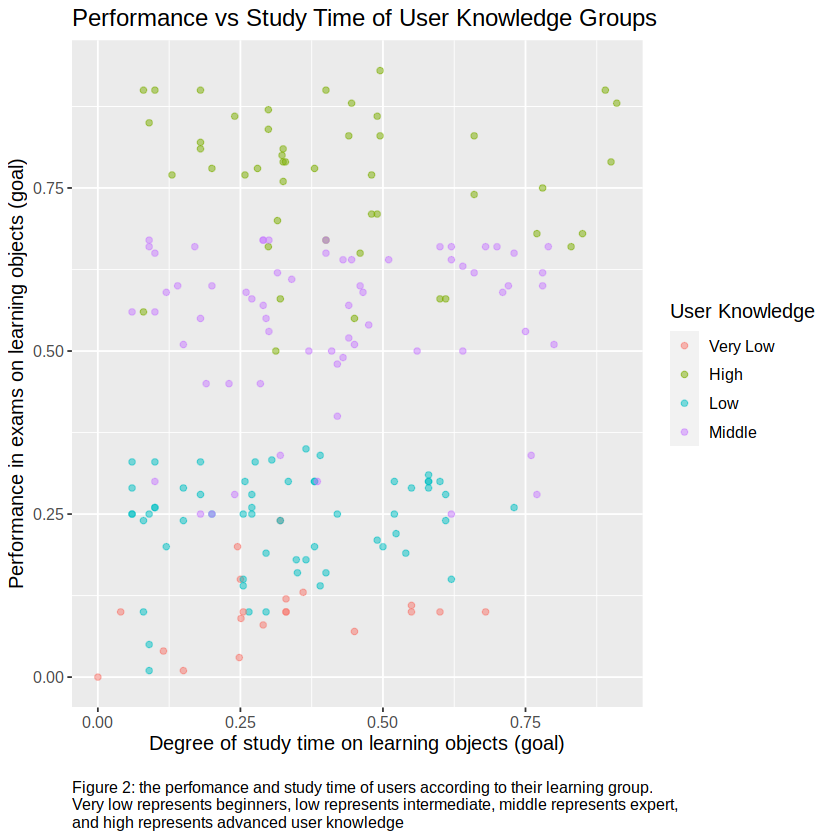

In [8]:
dc_machines_plot_study_vs_goal <- dc_machines_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge", 
        caption = "
Figure 2: the perfomance and study time of users according to their learning group.
Very low represents beginners, low represents intermediate, middle represents expert, 
and high represents advanced user knowledge") +
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    ggtitle("Performance vs Study Time of User Knowledge Groups")
dc_machines_plot_study_vs_goal

## Methods

### Classification System

We will be using the k-nearest neighbors (KNN) algorithm in our project to determine if the user knowledge level of an individual can be predicted using their study habits and exam performance. 

We will conduct our data analysis using **KNN classification** since we are predicting a categorical variable. 

We will be using the following variables: 
- user_knowledge (class)
- study_time_goal (predictor)
- repetition (predictor)
- performance_goal (predictor)

### Steps
1.  Balance the data by upsampling the very_low category of user_knowledge
2.  Build the recipe using user_knowledge as the classifier, study_time_goal, repetition and performance_goal as the predictors, and the training set as the data.  
3.  Choose the appropriate K-value for the training set using 5-fold cross-validation and compare accuracy for each selection of K (tune the model).
4.  Create the KNN model using the selected K value.
5.  Train the classifier using the training set.
6.  Predict the labels for the unseen testing set.
7.  Evaluate accuracy and create a confusion matrix to assess precision and recall.
8.  Analyze performance using precision, recall, and accuracy.
9.  Discuss outcomes and provide suggestions for improving the model.

### Visualization


We will visualize our data by:
1. Plotting neighbors vs. accuracy of the cross-validation
2. Displaying the confusion matrix

## Expected Outcomes and Significance

We expect to see that exam performance and study time are good predictors of user knowledge.

We believe that these findings could contribute to predicting user knowledge for web-based learning applications ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

Future questions that this could lead to include how we can adjust the tasks for students learning a topic to create a dynamic and adaptive learning experience. For example, the creation of an intelligent artificial tutor that could tailor content based on user knowledge.

# References

[1](https://doi.org/10.1109/access.2018.2847334) Al-Tarabily, M. M., Abdel-Kader, R. F., Azeem, G. A., & Marie, M. I. (2018). Optimizing Dynamic Multi-Agent Performance in E-Learning Environment, 35631–35645. https://doi.org/10.1109/access.2018.2847334 

[2](https://doi.org/10.1016/B978-0-444-70536-5.50051-8) Chignell, M. H., Hancock, P. A., & Helander, M. (1988). Chapter 46 - Intelligent Interface Design. In Handbook of Human-Computer Interaction (pp. 969–995). North Holland. https://doi.org/10.1016/B978-0-444-70536-5.50051-8

[3](https://doi.org/10.1016/j.knosys.2012.08.009) Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. *Knowledge-Based Systems, 37*, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009 

[4](https://doi.org/10.24432/C5231X) Kahraman, H. T., Colak, I., & Sagiroglu, S. (2013). User Knowledge Modeling. *UCI Machine Learning Repository*. https://doi.org/10.24432/C5231X.

[5](https://datasciencebook.ca/) Timbers, T., Campbell, T., & Lee, M. (2023) Data Science: A First Introduction. CRC Press, Taylor & Francis Group. https://datasciencebook.ca/